In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


## 학습 목표
- CNN으로 특성을 추출해서 손글씨 숫자 데이터 분류

- CNN 층
  - Conv2D() : 특성 추출기
  - MaxPooling2D() : 크기 축소
  - Flatten() : 특성 이미지를 1차원으로 변환

In [16]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [17]:
import numpy as np
import tensorflow as tf

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [18]:
# 스케일링
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [20]:
# CNN에 입력으로 하려면 색상 차원이 필요 (흑백 1, 컬러 3)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

- 샘플링 : 일부 데이터만 이용해서 학습
  - 중요 특성만 뽑기 때문에 데이터의 수가 적어도 잘 분류하는지 확인

In [21]:
X_train = X_train[:3000]
y_train = y_train[:3000]
X_test = X_test[:900]
y_test = y_test[:900]

X_train.shape, X_test.shape

((3000, 28, 28, 1), (900, 28, 28, 1))

- 라벨 원핫 인코딩

In [22]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

y_train_oh.shape, y_test_oh.shape

((3000, 10), (900, 10))

- 특성 추출기(CNN) + 분류기 (Dense) 신경망 설계

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Conv2D() : 특성 추출기
# C-C-M / C-C-C-M -> Conv2D 층을 두 개 이상 쌓고 MaxPooling을 하나 쌓는 것이 일반적
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
                 input_shape=(28,28,1)))

# MaxPooling() : 특성 이미지 축소
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten() : 특성 이미지를 1차원으로 변환
model.add(Flatten())

# 분류기
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               2769408   
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 2774858 (10.59 MB)
Trainable params: 2774858 (10.59 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model2 = Sequential()

# Conv2D() : 특성 추출기
# C-C-M / C-C-C-M -> Conv2D 층을 두 개 이상 쌓고 MaxPooling을 하나 쌓는 것이 일반적
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu",
                 input_shape=(28,28,1)))
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))

# MaxPooling() : 특성 이미지 축소
model2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten() : 특성 이미지를 1차원으로 변환
model2.add(Flatten())

# 분류기
model2.add(Dense(units=512, activation="relu"))
model2.add(Dense(units=10, activation="softmax"))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               2359808   
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                      

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

- 베스트 모델 저장, 학습 중단 기능 추가

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

file_name = './model/model_cnn_{epoch:02d}_{loss:.3f}_{val_loss:.3f}.hdf5'

mc = ModelCheckpoint(filepath=file_name, monitor='val_loss',
                             verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=10)

h1 = model.fit(X_train, y_train_oh, epochs=30, batch_size=32,
               validation_data=(X_test, y_test_oh), callbacks=[mc,es])

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.8387
Epoch 1: val_loss improved from inf to 0.30844, saving model to ./model/model_cnn_01_0.553_0.308.hdf5
94/94 [==============================] - 8s 78ms/step - loss: 0.5526 - accuracy: 0.8387 - val_loss: 0.3084 - val_accuracy: 0.9067
Epoch 2/30
93/94 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9530
Epoch 2: val_loss improved from 0.30844 to 0.23240, saving model to ./model/model_cnn_02_0.162_0.232.hdf5
94/94 [==============================] - 5s 50ms/step - loss: 0.1616 - accuracy: 0.9533 - val_loss: 0.2324 - val_accuracy: 0.9311
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9750
Epoch 3: val_loss improved from 0.23240 to 0.16626, saving model to ./model/model_cnn_03_0.091_0.166.hdf5
94/94 [==============================] - 6s 65ms/step - loss: 0.0907 - accuracy: 0.9750 - val_loss: 0.1663 - val_accuracy: 0.9444
Epoch 4/30
93/

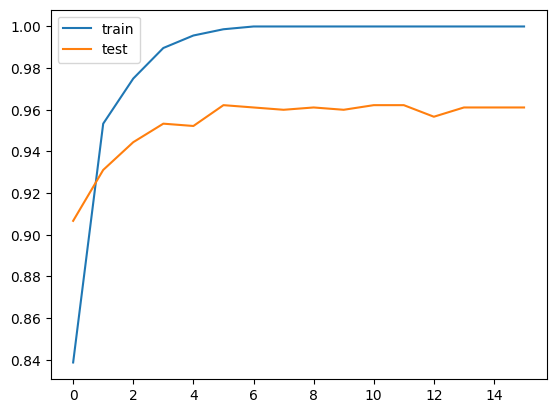

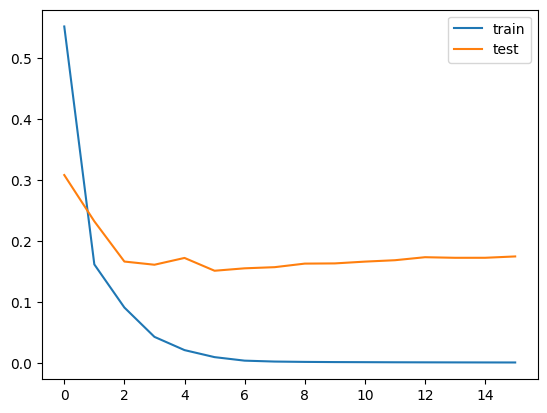

In [27]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h1.history['accuracy'], label = "train")
plt.plot(h1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h1.history['loss'], label = "train")
plt.plot(h1.history['val_loss'], label = "test")
plt.legend()
plt.show()

- ex06의 손글씨 코드 불러오기

In [33]:
# 이미지 불러오기!
import PIL.Image as pimg
import numpy as np
import matplotlib.pyplot as plt

img = pimg.open('./data/8.png').convert('L') # convert('L') : 흑백으로 변환
img = np.array(img)

# testimg = img.reshape(-1, 28*28)  # reshape할 때 -1 -> 차원이 하나 추가
testimg = img.reshape(-1, 28, 28, 1)  # CNN이라 색상 차원 추가

testimg = testimg/255.0

pred = model.predict(testimg)
print(pred)
print(pred.argmax())

1/1 [==============================] - 0s 21ms/step
[[5.0462041e-11 8.7755792e-12 5.2806314e-05 5.5189705e-01 1.0559690e-09
  3.6574482e-05 2.7819838e-14 3.2554064e-09 4.4801313e-01 4.3210827e-07]]
3
